本节中，我们将学习如何利用Python的来实现具有一个隐藏层的平面数据分类问题。

**使用到的库说明**

- numpy：Python科学计算中最重要的库

- sklearn：提供了一些简单而有效的工具用于数据挖掘和数据分析。

- matplotlib：Python画图的库


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
 
%matplotlib inline
 
np.random.seed(1) # 设置随机数的seed，保证每次获取的随机数固定

In [63]:
# 我们需要执行load_planar_dataset()来加载数据集

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

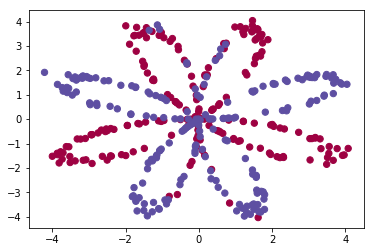

In [64]:
# 加载数据集，并用图像将其显示出来：

X, Y = load_planar_dataset()
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral);


图像像是一朵花儿，对于y=0时，显示为红色的点；而当y=1时，显示的是蓝色的点。

我们的目的是希望建立一个模型可以将两种颜色的点区分开。

In [65]:
# 接下来，我们看一下训练集的维度吧：
 
shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]  # training set size
 
print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


#### 简单的逻辑回归实现

在建立一个神经网络之前，我们先用逻辑回归算法来解决一下该问题。

我们可以直接使用sklearn的内置函数来完成。

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


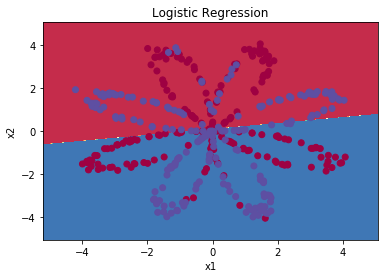

In [66]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, np.ravel(Y.T))

# 接下来，我们用图像来显示出来模型为分界线：

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0, :], cmap=plt.cm.Spectral)

plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")
 
# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")


**从分割图像和预测准确性上，我们可以看出，由于该应用不是线性可分的，因此，Logistic回归算法无法得到一个令人满意的结果。**

### 神经网络模型

对于含有一个隐藏层的神经网络而言，其模型结构如下：

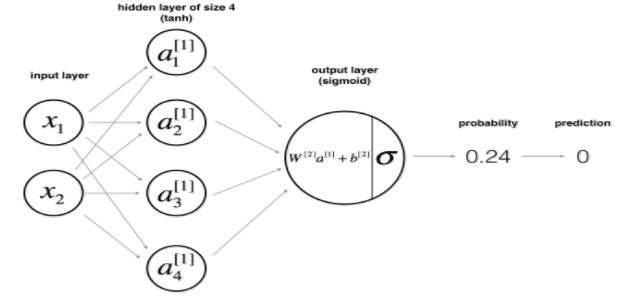

从数学公式的角度来看，对于每个训练样本x﻿(i)，计算公式如下：

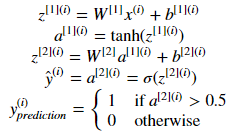

通过结合样本的真实输入y，计算代价函数J的方式如下：

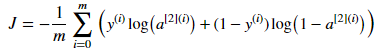

### 对于建立一个神经网络的通用过程如下：

- Step1：设计网络结构，例如多少层，每层有多少神经元等。

- Step2：初始化模型的参数

- Step3：循环

    - Step3.1：前向传播计算

    - Step3.2：计算代价函数

    - Step3.3：反向传播计算

    - Step3.4：更新参数

接下来，我们就逐个实现这个过程中需要用到的相关函数，并整合至nn_model()中。

当nn_model()模型建立好后，我们就可以用于预测或新数据集的训练与使用。

**定义神经网络结构**

给定如下变量：

n_x：输入层神经元的数目

n_h：隐藏层神经元的数目

n_y：输出层神经元的数目

此处，我们需要根据X和Y来确定n_x和n_y，另外n_h设置为4。

In [67]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    
    return (n_x, n_h, n_y)

# 获取伪测试集
def layer_sizes_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(5, 3)
    Y_assess = np.random.randn(2, 3)
    return X_assess, Y_assess

X_assess, Y_assess = layer_sizes_test_case() 
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))


The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**初始化模型参数**

为了实现初始化模型参数的任务，我们需要实现一个initialize_parameters()函数。

按照之前理论课的内容，我们需要用一个较小的随机数来初始化W，用零向量初始化b。

In [68]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) 
    W1 = np.random.randn(n_h, n_x) * 0.01 
    b1 = np.zeros((n_h, 1)) * 0.01 
    W2 = np.random.randn(n_y, n_h) * 0.01 
    b2 = np.zeros((n_y, 1)) * 0.01 
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

**循环**

接下来，就是整个训练过程中最重要的阶段了。

我们需要实现整个训练过程的循环过程。

首先，我们从前向传播开始：

In [69]:
def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation function
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

此时，根据forward_propagation()已经可以计算得到A[2]了，接下来，我们需要结合真实结果来计算代价函数：

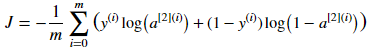

In [70]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example
 
    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1 - A2), 1 - Y)
    cost = -np.sum(logprobs) / m
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

第三步，我们需要利用之前的cache来进行反向传播计算，计算公式如下：

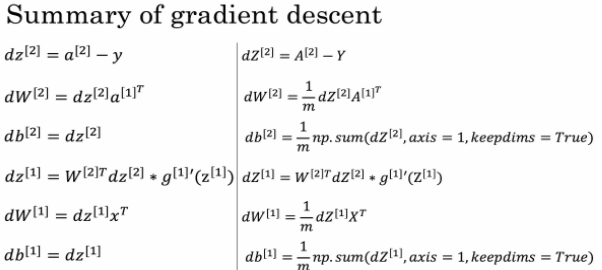

In [71]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - np.power(A1, 2)))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

g[1](z) = tanh(z)，其导数函数如下：



最后一步，我们需要利用反向传播计算得到的dW, db来更新W和b。

通用的更新公式如下：

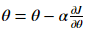

其中，alpha表示学习速率，theta表示被更新的变量。

此外，需要说明的是，学习速度选择的适当与否对最终的收敛结果有着很大的影响。

一个合适的学习速率可以使得函数快速且稳定的到达最优值附近。

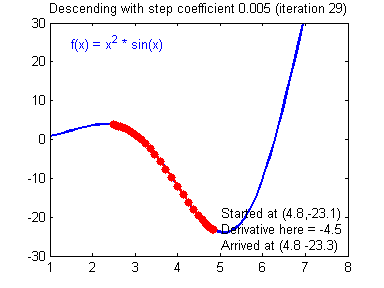

而一个过大的学习速度会导致其无法正常收敛而出现大幅度的波动：

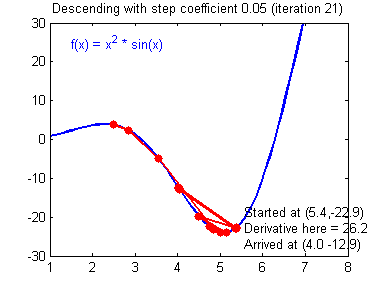

In [72]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

**整合成为nn_model()**

接下来，我们希望将之前准备的几个函数整合到模型中，可以方便快速的直接使用：

In [73]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
 
    return parameters

**预测**

除了训练模型外，我们还需要使用我们的模型来进行预测。

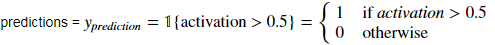

通常，我们会设置一个阈值，当预测结果大于该阈值时，我们认为其为1，否则为0。0.5是一个很常用的阈值。

In [74]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    return predictions

到目前为止，我们已经实现了完整的神经网络模型和预测函数，接下来，我们用我们的数据集来训练一下吧：

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219419
Cost after iteration 9000: 0.218548


Text(0.5,1,'Decision Boundary for hidden layer size 4')

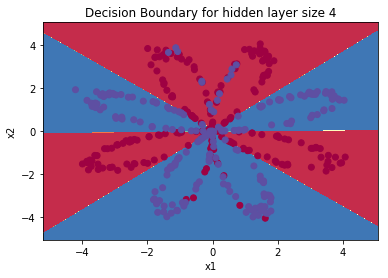

In [75]:
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)
 
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

分类曲线如上图所示，接下来，我们使用预测函数计算一下我们模型的预测准确度：

In [76]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%') 


Accuracy: 90%


相比47%的逻辑回归预测率，使用含有一个隐藏层的神经网络预测的准确度可以达到90%。

**调整隐藏层神经元数目观察结果**

接下来，我们使用包含不同隐藏层神经元的模型来进行训练，以此来观察神经元数量度模型的影响。

我们分别适用包含1,2,3,4,5,20,50个神经元的模型来进行训练：

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.5 %
Accuracy for 50 hidden units: 90.25 %


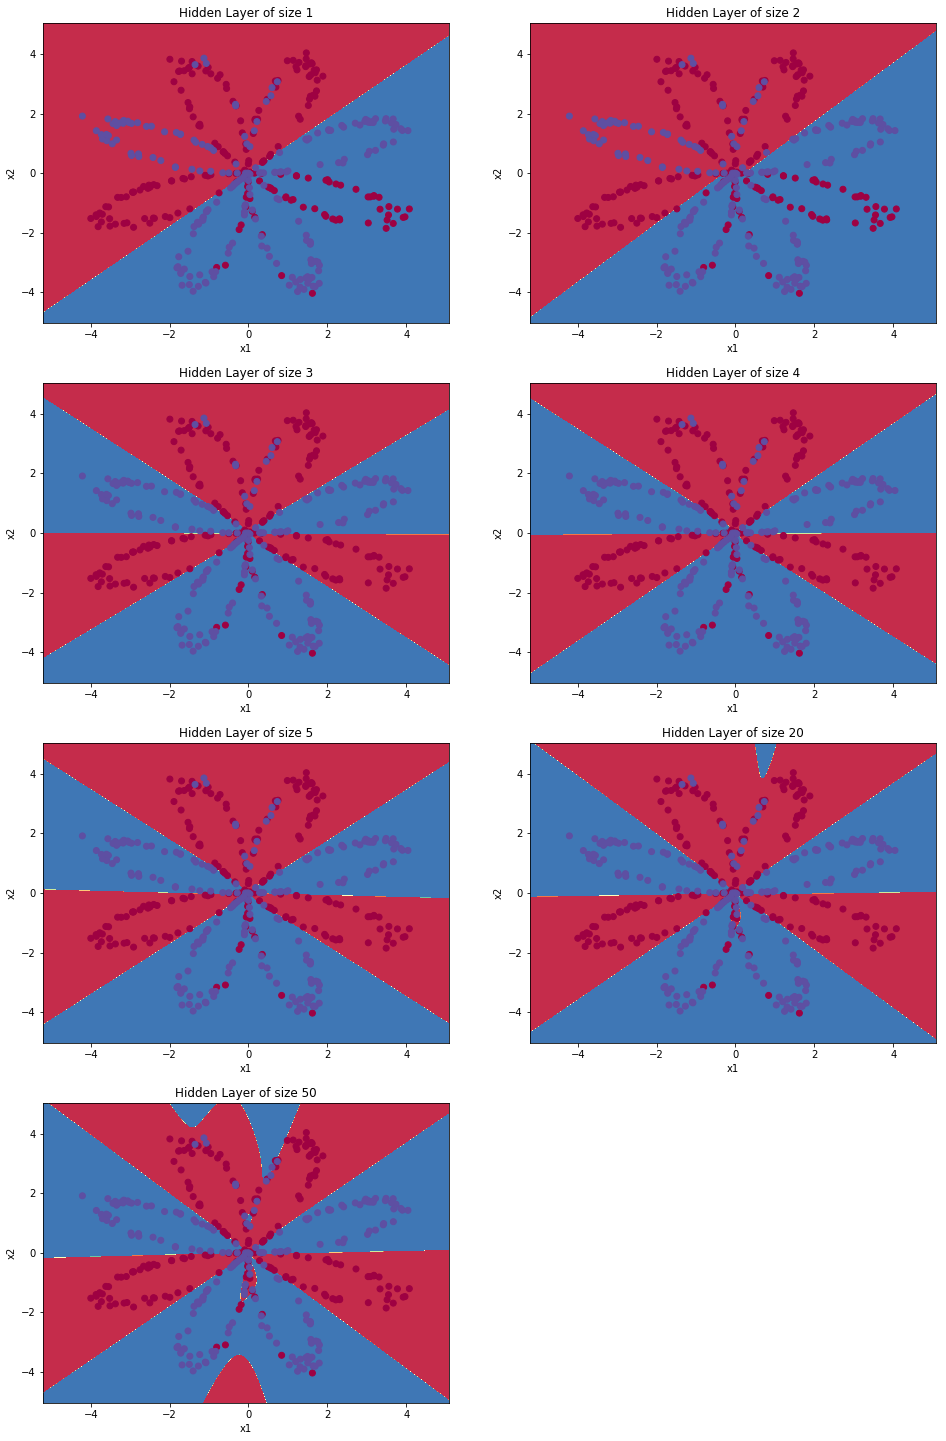

In [77]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

对比上述图像，我们可以发现：

1. 神经元数目越多，生成的分割曲线越复杂，最终越可能导致过拟合。

2. 对该应用而言，最好的神经元数目是n_h=5，此时，几乎没有过拟合问题发生。

3. 后续的课程中，我们将继续讲解正则化，通过一些正则化方法，我们可以有效的避免过拟合的问题发生。

### 用其他数据集进行性能测试

如果你想要用其他的数据集进行练习，这儿可以给你提供一些额外的训练集：

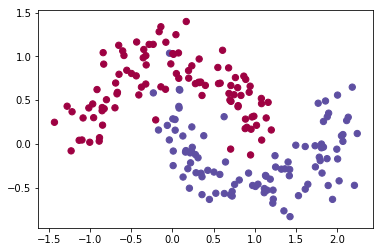

In [78]:
def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()
 
datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}
 
### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###
 
X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])
 
# make blobs binary
if dataset == "blobs":
    Y = Y%2
 
# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral);